In [1]:
import pandas as pd
import numpy as np
from rotamer_libraries import RotamerClusters
import warnings
import mdtraj as md
import os
import yaml
import seaborn as sns
import matplotlib.pyplot as plt

warnings.filterwarnings('ignore')

# Generate new rotamer libraries

Let's have a look at the already available rotamer libraries we can use and their features:

In [2]:
with open('lib/libraries.yml') as f:
    data = yaml.load(f)
data

{'ATTO 390 C2R': {'author': 'D Montepietra, G Tesei, JM Martins, MBA Kunze, RB Best, K Lindorff-Larsen',
  'citation': 'TBD',
  'filename': 'T39_C2R_cutoff30',
  'licence': 'GPLv3',
  'mu': ['C1', 'C10 and resname T39'],
  'negative': [],
  'positive': [],
  'r': ['C7 and resname T39']},
 'ATTO 390 L1R': {'author': 'D Montepietra, G Tesei, JM Martins, MBA Kunze, RB Best, K Lindorff-Larsen',
  'citation': 'TBD',
  'filename': 'T39_L1R_cutoff30',
  'licence': 'GPLv3',
  'mu': ['C1', 'C10 and resname T39'],
  'negative': [],
  'positive': [],
  'r': ['C7 and resname T39']},
 'ATTO 425 C2R': {'author': 'D Montepietra, G Tesei, JM Martins, MBA Kunze, RB Best, K Lindorff-Larsen',
  'citation': 'TBD',
  'filename': 'T42_C2R_cutoff30',
  'licence': 'GPLv3',
  'mu': ['C1', 'C10 and resname T42'],
  'negative': [],
  'positive': [],
  'r': ['C7 and resname T42']},
 'ATTO 425 L1R': {'author': 'D Montepietra, G Tesei, JM Martins, MBA Kunze, RB Best, K Lindorff-Larsen',
  'citation': 'TBD',
  'file

All the rotamer libraries are composed of three different files: 
- **Trajectory file** with all the rotamer conformations (in `dcd` format);<br><br>
- **Structure file** with a protein conformation (in `pdb` format);<br><br>
- **Weight file** containing the populations of each  chromophore conformation (in `txt` format).

<br>The `libraries.yml` file contains other specifics for the rotamer library:
- `name` composed of three different parts: the producer (AlexaFluor, ATTO, Lumiprobe), the peak wavelength, and the linker that connects the dye to the protein (C1R, C2R, C3R, L1R, L2R, B1R). An example is AlexaFluor 488 C1R.<br><br>
- `filename`: Acronym of the dye + linker pair;<br><br>
- `mu`: selection of the two atoms that form the dye transition dipole moment vector;<br><br>
- `positive`: selection of the positively charged atoms;<br><br>
- `negative`: selection of the negatively charged atoms;<br><br>
- `r`: selection of the dye central atom  for dye-dye distance calculations<br>
>The atom names must correspond to those reported in the `pdb` structure file.

To create a rotamer library you first need a dye+linker trajectory and a protein structure saved in a directory named after the name of your chromophore.<br>
>E.g. The AlexaFluor 488 C1R trajectory and structure is saved in `lib/A48_C1R`.

1- Identify all the dihedral angles in the linker

![title](A48_C1R_dihedrals.png)

2- Find the names of the atoms involved in the dihedrals

![title](A48_C1R_atoms.png)


In [3]:
dyes_atoms = {}

dyes_atoms['A48_C1R'] = {'atoms': [['N', 'CA', 'C6', 'S1'], ['CA', 'C6', 'S1', 'C7'], ['C6', 'S1', 'C7', 'C10'], 
                     ['C10', 'N3', 'C11', 'C12'], ['N3', 'C11', 'C12', 'C13'], ['C11', 'C12', 'C13', 'C14'], 
                     ['C12', 'C13', 'C14', 'C15'], ['C13', 'C14', 'C15', 'N99'], ['C14', 'C15', 'N99', 'C99'], 
                     ['C15', 'N99', 'C99', 'C17'], ['N99', 'C99', 'C17', 'C15'], ['C15', 'C14', 'C7', 'C8']],
                    'resname': [['C1R', 'C1R', 'C1R', 'C1R'], ['C1R', 'C1R', 'C1R', 'C1R'], ['C1R', 'C1R', 'C1R', 'C1R'],
                   ['C1R', 'C1R', 'C1R', 'C1R'], ['C1R', 'C1R', 'C1R', 'C1R'], ['C1R', 'C1R', 'C1R', 'C1R'],
                   ['C1R', 'C1R', 'C1R', 'C1R'], ['C1R', 'C1R', 'C1R', 'C1R'], ['C1R', 'C1R', 'C1R', 'A48'],
                   ['C1R', 'C1R', 'A48', 'A48'], ['C1R', 'A48', 'A48', 'A48'], ['A48', 'A48', 'A48', 'A48']]}

Obtain the indices associated to the atoms

In [4]:
# List all directories for chromophores
for directory in ['A48_C1R']:
    
    if os.path.exists('lib/' + directory + '/conf_ed.gro'):
        
        # print(directory)
        
        t = md.load_xtc(f'lib/{directory}/traj.xtc', f'lib/{directory}/conf_ed.gro')
        table, bonds = t.top.to_dataframe()
        
        ind = []
        
        # Iterate over all dihedrals of the linker
        # TODO: chiamare i dihedrals+resname dei vari dye+linkers
        for num_dih, dih in enumerate(dyes_atoms[directory]['atoms']):
            
            # Iterate over every atom forming the dihedral
            for atom in range(0, 4):
                
                 ind += table.loc[(table['resName'] == dyes_atoms[directory]['resname'][num_dih][atom]) & (table['name'] == dih[atom])].index.tolist()

    else:
        continue
    
    # Reshape the array to (number_of_dihedrals, 4)
    indices = np.array(ind).reshape((len(dyes_atoms[directory]['atoms']), 4)).tolist()
    print(directory, '\n', indices, '\n')

A48_C1R 
 [[85, 52, 56, 59], [52, 56, 59, 60], [56, 59, 60, 66], [66, 65, 68, 71], [65, 68, 71, 74], [68, 71, 74, 77], [71, 74, 77, 80], [74, 77, 80, 83], [77, 80, 83, 40], [80, 83, 40, 33], [83, 40, 33, 31], [31, 30, 13, 14]] 



Create a dictionary with all the indices associated to the dihedral atoms

In [5]:
dyes = {}

dyes['A48_C1R'] = {'indices': [[85, 52, 56, 59], [52, 56, 59, 60], [56, 59, 60, 66], 
                               [66, 65, 68, 71], [65, 68, 71, 74], [68, 71, 74, 77], 
                               [71, 74, 77, 80], [74, 77, 80, 83], [77, 80, 83, 40], 
                               [80, 83, 40, 33], [83, 40, 33, 31], [31, 30, 13, 14]], 
                   'peaks': []}

Create a DataFrame for the dihedrals. It will have two columns: 
- `indices`: atom indices forming the dihedral angles of the linker.
- `peaks`: peak frame indices (will be filled during the rotamer library calculation)

In [6]:
df = pd.DataFrame(dyes).T
df

,indices,peaks
A48_C1R,"[[85, 52, 56, 59], [52, 56, 59, 60], [56, 59, ...",[]


Now you have all that is needed to create a new rotamer library. You just have to create a `RotamerCluster` object passing as parameters the DataFrame with the dihedral data (`df`) and the clustering cutoffs you want (`cutoff`).<br>
<br> You can also specify the directories in which retrieve the dye+linker data (`libpath`) and where to save the newly generated rotamer libraries files (`path`)

In [ ]:
rotamercluster = RotamerClusters(df=df, cutoff=[10, 20, 30], 
                                 libpath='lib/', path='lib/genLIB2/')
rotamercluster.run()

Dye + Linker: A48_C1R

Calculating dihedral angles...

Computing dihedral distributions and peaks...
Dihedral 1
Peak indices [ 18 119 242] 
 peak dihedral angles [-161.5  -60.5   62.5]
Dihedral 2
Peak indices [120 269 354] 
 peak dihedral angles [-59.5  89.5 174.5]
Dihedral 3
Peak indices [104 228   1] 
 peak dihedral angles [ -75.5   48.5 -178.5]
Dihedral 4
Peak indices [ 85 273] 
 peak dihedral angles [-94.5  93.5]
Dihedral 5
Peak indices [  1 114 246] 
 peak dihedral angles [-178.5  -65.5   66.5]
Dihedral 6
Peak indices [106 248 356] 
 peak dihedral angles [-73.5  68.5 176.5]
Dihedral 7
Peak indices [110 244 358] 
 peak dihedral angles [-69.5  64.5 178.5]
Dihedral 8
Peak indices [117 241 358] 
 peak dihedral angles [-62.5  61.5 178.5]
Dihedral 9
Peak indices [ 80 278   0] 
 peak dihedral angles [ -99.5   98.5 -179.5]
Dihedral 10
Peak indices [358] 
 peak dihedral angles [178.5]
Dihedral 11
Peak indices [179] 
 peak dihedral angles [-0.5]
Dihedral 12
Peak indices [269] 
 peak dihedra

After this calculations, you will have the trajectory, structure and weight file for the new rotamer library, at the different cutoffs you have specified.

### Visualizing the clusters

You can visualize the obtained clusters and the corresponding peaks using two functions in the `RotamerClusters` object: `plotClustHist` (for a histogram representation), and `plotClustPolar` (for a polar coordinate representation)

12
12


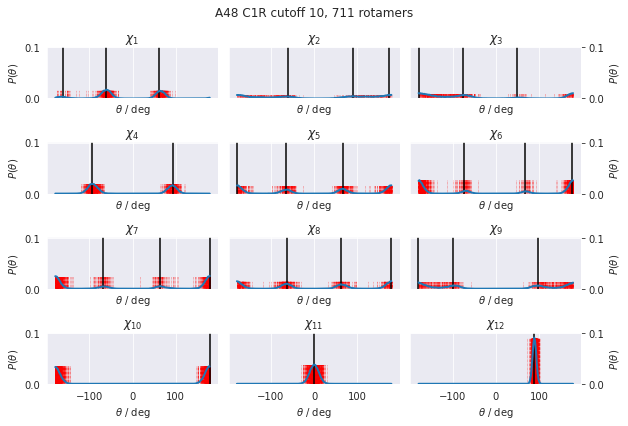

12
12


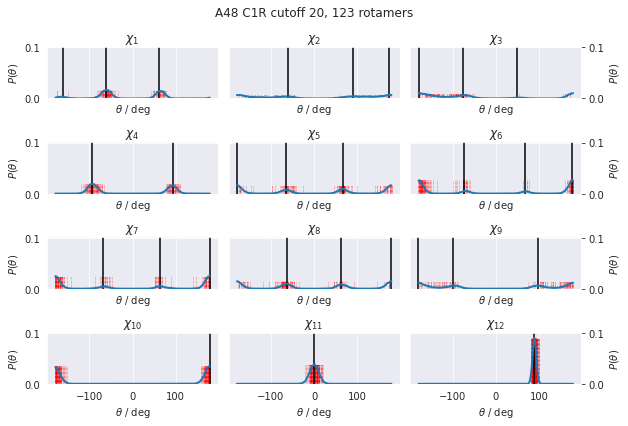

12
12


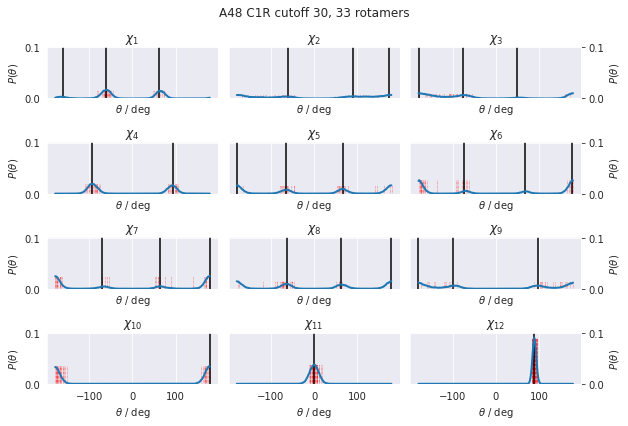

In [9]:
for dye in df.index:
    for c in [10, 20, 30]:
        rotamercluster.plotClustHist(dye=dye, cutoff=c)

In [ ]:
for dye in df.index:
    for c in [10, 20, 30]:
        rotamercluster.plotClustPolar(dye=dye, cutoff=c)

### Making the new library usable

To use the new Rotamer Library, you have to insert it in the `libraries.yml` file, to be able to call it.<br> Simply create a dictionary with the new library data.
>`mu`, `r`, `negative`, `positive` atom selections must be MDAnalysis-compatible

>`filename` is the prefix name of the files saved in `libpath`.

In [ ]:
libraries_dict = {'Alexa 488 C1R': {'author': 'D Montepietra, G Tesei, JM Martins, MBA Kunze, RB Best, K Lindorff-Larsen',
                                    'citation': 'TBD',
                                    'licence': 'GPLv3',
                                    'filename': 'A48_C1R_cutoff30',
                                    'mu': ['C2', 'C13 and resname A48'],
                                    'r': ['C7 and resname A48'],
                                    'negative': ['S1 and resname A48',
                                                 'S2 and resname A48',
                                                 'C20 and resname A48'],
                                     'positive': ['N1 and resname A48', 'N2 and resname A48']}}

>Create a copy of the current `library.yml` file called `libraries_new.yml`

In [ ]:
# Read current libraries yaml file
with open('lib/libraries_new.yml', 'r') as yamlfile:
    cur_yaml = yaml.safe_load(yamlfile)
    cur_yaml.update(libraries_dict)

# Write new chromophore data to yaml file
if cur_yaml:
    with open('lib/libraries_new.yml', 'w') as yamlfile:
        yaml.safe_dump(cur_yaml, yamlfile)

After writing the new chromophore data to the `libraries_new.yml` file, check it and then call it `libraries.yml`, to be used in `FRETpredict`

In [12]:
# Visualize yaml file
with open('lib/libraries.yml') as f:
    data = yaml.load(f)
data

{'ATTO 390 C2R': {'author': 'D Montepietra, G Tesei, JM Martins, MBA Kunze, RB Best, K Lindorff-Larsen',
  'citation': 'TBD',
  'filename': 'T39_C2R_cutoff30',
  'licence': 'GPLv3',
  'mu': ['C1', 'C10 and resname T39'],
  'negative': [],
  'positive': [],
  'r': ['C7 and resname T39']},
 'ATTO 390 L1R': {'author': 'D Montepietra, G Tesei, JM Martins, MBA Kunze, RB Best, K Lindorff-Larsen',
  'citation': 'TBD',
  'filename': 'T39_L1R_cutoff30',
  'licence': 'GPLv3',
  'mu': ['C1', 'C10 and resname T39'],
  'negative': [],
  'positive': [],
  'r': ['C7 and resname T39']},
 'ATTO 425 C2R': {'author': 'D Montepietra, G Tesei, JM Martins, MBA Kunze, RB Best, K Lindorff-Larsen',
  'citation': 'TBD',
  'filename': 'T42_C2R_cutoff30',
  'licence': 'GPLv3',
  'mu': ['C1', 'C10 and resname T42'],
  'negative': [],
  'positive': [],
  'r': ['C7 and resname T42']},
 'ATTO 425 L1R': {'author': 'D Montepietra, G Tesei, JM Martins, MBA Kunze, RB Best, K Lindorff-Larsen',
  'citation': 'TBD',
  'file